In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', '..')))

import argparse
from pprint import pp
import torch
from torch import nn
from tqdm import tqdm
import numpy as np
import json
import os
from omegaconf import OmegaConf
from torch.utils.tensorboard import SummaryWriter

from lpn.utils import load_dataset, load_config
from lpn.utils import get_model
from lpn.utils import get_loss_hparams_and_lr, get_loss
from lpn.utils import trainer
from lpn.utils import utils
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_config_path = "./configs/test_dataset.json"

In [3]:
model_config_path = "./models/ne_lpn_sub_sq/s=0.1/model_config.json"
model_weight_path = "./models/ne_lpn_sub_sq/s=0.1/model.pt"

#import model as cuda
model_config = load_config(model_config_path)
model = get_model(model_config).to(device)
model.load_state_dict(torch.load(model_weight_path)["model_state_dict"])

init weights


<All keys matched successfully>

In [4]:
Lpn_config_path = "./models/lpn/s=0.1/model_config.json"
Lpn_weight_path = "./models/lpn/s=0.1/model.pt"

lpn_config = load_config(Lpn_config_path)
lpn = get_model(lpn_config).to(device)
lpn.load_state_dict(torch.load(Lpn_weight_path)["model_state_dict"])

init weights


<All keys matched successfully>

In [5]:
dataset_config = load_config(dataset_config_path)
test_dataset = load_dataset(dataset_config, "test")
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

dataset:  celeba


In [6]:
noise_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
ne_avg_losses = []
lpn_avg_losses = []

for noise in noise_levels:

    ne_running_loss = 0 
    lpn_running_loss = 0
    noisy_running_loss = 0
    num_steps = 1000
    for step, batch in enumerate(test_data_loader):
        if step >= num_steps:
            break

        clean_image = batch["image"].to(device)
        noised_image = clean_image + noise * torch.randn_like(clean_image)

        # get denoised images
        with torch.no_grad():
            ne_output = model(noised_image)
            lpn_output = lpn(noised_image)
        
        mse_loss = nn.MSELoss()
        ne_loss = mse_loss(ne_output, clean_image)
        lpn_loss = mse_loss(lpn_output, clean_image)

        noisy_running_loss += mse_loss(noised_image, clean_image).item()
        ne_running_loss += ne_loss.item()
        lpn_running_loss += lpn_loss.item()
    
    ne_avg_loss = ne_running_loss / num_steps
    lpn_avg_loss = lpn_running_loss / num_steps
    noisy_avg_loss = noisy_running_loss / num_steps
    ne_avg_losses.append(ne_avg_loss)
    lpn_avg_losses.append(lpn_avg_loss)

    print(f"Noise Level: {noise}")
    print(f"Noisy Avg Loss: {noisy_avg_loss}")
    print(f"NE avg loss: {ne_avg_loss}")
    print(f"LPN avg loss: {lpn_avg_loss}")
    print(f"LPN avg loss - NE avg loss: {lpn_avg_loss - ne_avg_loss}\n")

Noise Level: 0.1
Noisy Avg Loss: 0.009999631425365805
NE avg loss: 0.002134344473364763
LPN avg loss: 0.0006821837061434053
LPN avg loss - NE avg loss: -0.0014521607672213577

Noise Level: 0.2
Noisy Avg Loss: 0.04000158689916134
NE avg loss: 0.003447733152192086
LPN avg loss: 0.008296215967740864
LPN avg loss - NE avg loss: 0.004848482815548778

Noise Level: 0.3
Noisy Avg Loss: 0.0899865986034274
NE avg loss: 0.0058498631473630665
LPN avg loss: 0.0462058300934732
LPN avg loss - NE avg loss: 0.04035596694611013

Noise Level: 0.4
Noisy Avg Loss: 0.15998521897196769
NE avg loss: 0.009783117554150522
LPN avg loss: 0.1613757793903351
LPN avg loss - NE avg loss: 0.15159266183618458

Noise Level: 0.5
Noisy Avg Loss: 0.24991104516386986
NE avg loss: 0.016473093062639235
LPN avg loss: 0.4135038355588913
LPN avg loss - NE avg loss: 0.3970307424962521

Noise Level: 0.6
Noisy Avg Loss: 0.3600511156022549
NE avg loss: 0.02657725247181952
LPN avg loss: 0.8243618001043796
LPN avg loss - NE avg loss: 

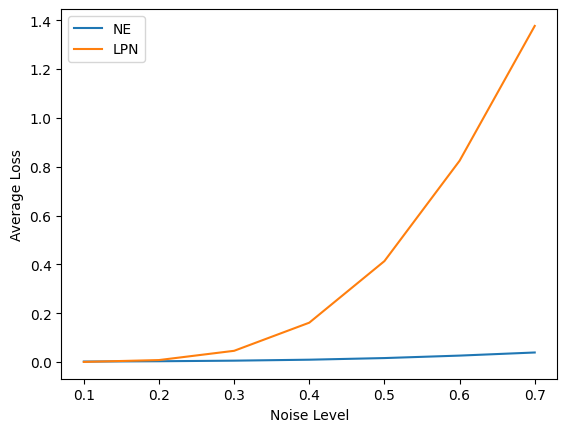

In [7]:
# plot results
plt.plot(noise_levels, ne_avg_losses, label="NE")
plt.plot(noise_levels, lpn_avg_losses, label="LPN")
plt.xlabel("Noise Level")
plt.ylabel("Average Loss")
plt.legend()
plt.show()